In [1]:
import torch
from model_1 import PricePredictionModel
from utils_1 import load_and_preprocess_data, get_dataloaders
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('listings.csv', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45533 entries, 0 to 45532
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            45533 non-null  int64  
 1   name                          45532 non-null  object 
 2   host_id                       45533 non-null  int64  
 3   host_name                     45531 non-null  object 
 4   host_since                    45531 non-null  object 
 5   host_response_time            35445 non-null  object 
 6   host_response_rate            35445 non-null  float64
 7   host_is_superhost             44281 non-null  object 
 8   neighbourhood_cleansed        45533 non-null  object 
 9   neighbourhood_group_cleansed  45533 non-null  object 
 10  latitude                      45533 non-null  float64
 11  longitude                     45533 non-null  float64
 12  property_type                 45533 non-null  object 
 13  r

In [3]:
df.head()

,id,name,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,neighbourhood_cleansed,neighbourhood_group_cleansed,...,bathrooms,bedrooms,beds,price,minimum_nights,availability_365,number_of_reviews,review_scores_rating,license,instant_bookable
0,670339032744709144,Westwood lovely three bedrooms three bathrooms,4780152,Moon,20/01/13,within a few hours,0.96,f,West Los Angeles,City of Los Angeles,...,3.0,3.0,3.0,399.0,30,365,0,NaN,NaN,f
1,37014494,Spanish style lower duplex near Beverly Hills,278288178,Ida,22/07/19,NaN,NaN,f,Beverlywood,City of Los Angeles,...,NaN,2.0,NaN,NaN,30,0,0,NaN,NaN,f
2,1024835174766068422,Charming Beverly Hills Home,513813179,Tiana,08/05/23,within a day,0.60,f,Beverly Hills,Other Cities,...,3.0,3.0,3.0,434.0,30,267,0,NaN,NaN,f
3,850744632375448560,Tianpu's warm room with bathroom,432956623,Dan,22/11/21,a few days or more,0.20,f,Temple City,Other Cities,...,1.0,1.0,1.0,49.0,1,364,1,3.00,NaN,f
4,953950676345326970,"Santa Monica apt, free parking, steps to the b...",528669205,Farkhat,29/07/23,within an hour,1.00,t,Santa Monica,Other Cities,...,1.0,0.0,1.0,231.0,5,193,44,4.93,Exempt,t


In [4]:
df.isnull().sum()

id                                  0
name                                1
host_id                             0
host_name                           2
host_since                          2
host_response_time              10088
host_response_rate              10088
host_is_superhost                1252
neighbourhood_cleansed              0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        8239
bedrooms                         3039
beds                             8334
price                            8237
minimum_nights                      0
availability_365                    0
number_of_reviews                   0
review_scores_rating            12146
license                         32730
instant_bookable                    0
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df.shape

(8366, 25)

In [7]:
columns_to_drop = ['id', 'name', 'host_id', 'host_since', 'host_name',
                       'latitude', 'longitude', 'license', 'neighbourhood_cleansed', 'property_type']
df = df.drop(columns=columns_to_drop)

In [8]:
df.head()

,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable
4,within an hour,1.0,t,Other Cities,Entire home/apt,2,1.0,0.0,1.0,231.0,5,193,44,4.93,t
6,within a few hours,1.0,f,City of Los Angeles,Entire home/apt,7,1.0,2.0,5.0,110.0,30,117,368,4.61,f
7,within an hour,1.0,t,City of Los Angeles,Entire home/apt,6,3.5,4.0,4.0,1179.0,2,356,35,4.97,f
8,within an hour,1.0,t,City of Los Angeles,Entire home/apt,8,4.5,4.0,4.0,1244.0,3,141,10,5.00,f
11,within an hour,1.0,t,Other Cities,Entire home/apt,5,1.0,2.0,3.0,213.0,2,244,23,4.74,t


# 1. 데이터 로드 및 전처리

In [9]:
X_train, X_val, y_train, y_val, scaler = load_and_preprocess_data()

/Users/hansohee/inhatc/4-2/머신러닝/LA_Airbnb/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [10]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

torch.Size([6692, 14])
torch.Size([1674, 14])
torch.Size([6692, 1])
torch.Size([1674, 1])


# 2. 모델 로드

In [11]:
input_size = X_train.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PricePredictionModel(input_size)
save_path = "best_model_4.pth"
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()

PricePredictionModel(
  (fc1): Linear(in_features=14, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

# 3. 예측 수행

In [12]:
# 예측 수행
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
with torch.no_grad():
    predictions = model(X_val_tensor).cpu().numpy()

/Users/hansohee/inhatc/4-2/머신러닝/LA_Airbnb/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


# 3. MSE, RMSE 계산

In [13]:
# 실제 값으로 변환
actual_predictions = scaler.inverse_transform(predictions)
actual_y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

# MSE, RMSE 계산
mse = mean_squared_error(actual_y_val, actual_predictions)
rmse = np.sqrt(mse)
print(f"MSE: {mse}, RMSE: {rmse}")

MSE: 162678.28116705644, RMSE: 403.33395736914645


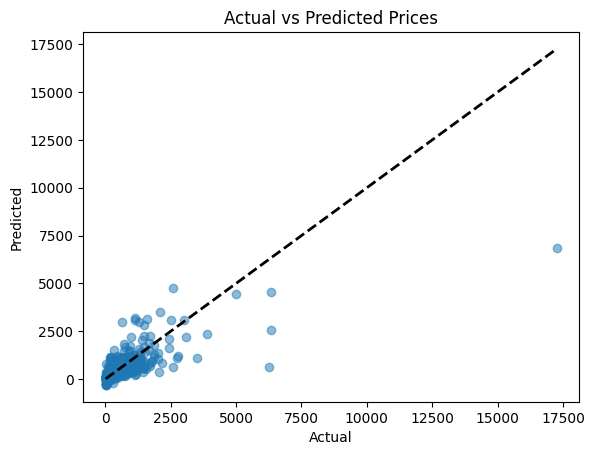

In [14]:
# # 예측 vs 실제값 시각화
# plt.scatter(y_test.numpy(), y_pred.numpy(), alpha=0.5)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', lw=2)
# plt.xlabel("Actual Prices")
# plt.ylabel("Predicted Prices")
# plt.title("Actual vs Predicted Prices")
# plt.show()
# 시각화
plt.scatter(actual_y_val, actual_predictions, alpha=0.5)
plt.plot([actual_y_val.min(), actual_y_val.max()], [actual_y_val.min(), actual_y_val.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Prices')
plt.show()

In [17]:
from torch.utils.data import DataLoader,Dataset
class BostonDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

test_dataset = BostonDataset(X_val, y_val)

# 4. DataLoader 생성
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

RMSE: 0.0234


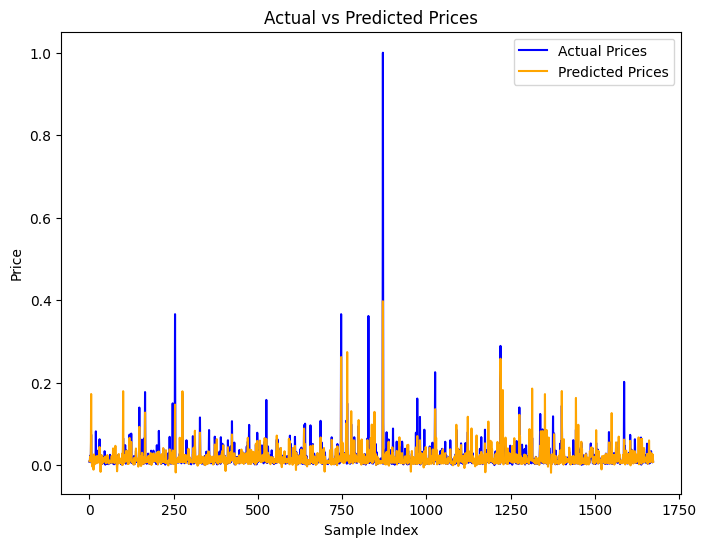

/Users/hansohee/inhatc/4-2/머신러닝/LA_Airbnb/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


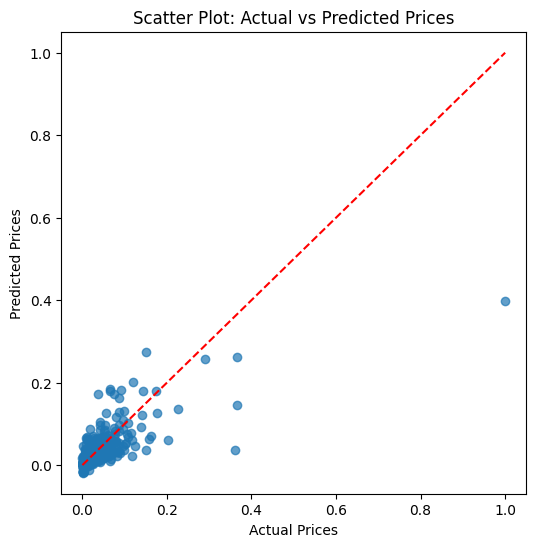

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 예측값과 실제값
model.eval()
y_pred = []
y_true = []
# train_loader, val_loader = get_dataloaders(X_train, X_val, y_train, y_val, 64)
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_pred.extend(output.squeeze().tolist())
        y_true.extend(y_batch.squeeze().tolist())

# 리스트를 numpy 배열로 변환
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# RMSE 계산
rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
print(f"RMSE: {rmse:.4f}")

# 1. 예측값 vs 실제값 비교 그래프
plt.figure(figsize=(8, 6))
plt.plot(y_true, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='orange')
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.show()

# 2. 예측값 vs 실제값 산점도
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', color='red')  # 대각선 기준선
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Scatter Plot: Actual vs Predicted Prices")
plt.show()
